In [6]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# ノンパラメトリックベイズモデル入門からクラスタリングへの応用

## 0 導入

### 0.1 クラスタリングと混合ガウス分布

K-平均アルゴリズムとは以下の最適化問題を解くことである.  
$$(z^*_{1:n}, \mu^*_{1:K})=arg min_{z_{1:n}, \mu_{1:K}}\sum^n_{i=1}\sum^K_{k=1}\delta(z_i = k)||x_i-\mu_k||^2$$  
この目的関数は、  
$$(z^*_{1:n}, \mu^*_{1:K})=arg min_{z_{1:n}, \mu_{1:K}}log\Pi^n_{i=1}N(x_i|\mu_{z_i},I)$$  
と書き換えることができる.

混合ガウスモデルの例.  
この[ページ](http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html#example-mixture-plot-gmm-py)のコードを実行.

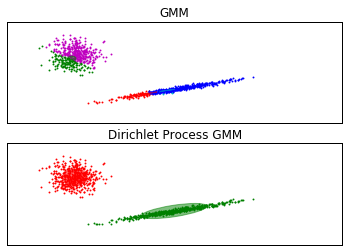

In [7]:
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

# Number of samples per component
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]

# Fit a mixture of Gaussians with EM using five components
gmm = mixture.GMM(n_components=5, covariance_type='full')
gmm.fit(X)

# Fit a Dirichlet process mixture of Gaussians using five components
dpgmm = mixture.DPGMM(n_components=5, covariance_type='full')
dpgmm.fit(X)

color_iter = itertools.cycle(['r', 'g', 'b', 'c', 'm'])

for i, (clf, title) in enumerate([(gmm, 'GMM'),
                                  (dpgmm, 'Dirichlet Process GMM')]):
    splot = plt.subplot(2, 1, 1 + i)
    Y_ = clf.predict(X)
    for i, (mean, covar, color) in enumerate(zip(
            clf.means_, clf._get_covars(), color_iter)):
        v, w = linalg.eigh(covar)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-10, 10)
    plt.ylim(-3, 6)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

plt.show()

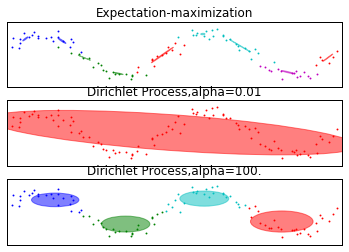

In [9]:
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture
from sklearn.externals.six.moves import xrange

# Number of samples per component
n_samples = 100

# Generate random sample following a sine curve
np.random.seed(0)
X = np.zeros((n_samples, 2))
step = 4 * np.pi / n_samples

for i in xrange(X.shape[0]):
    x = i * step - 6
    X[i, 0] = x + np.random.normal(0, 0.1)
    X[i, 1] = 3 * (np.sin(x) + np.random.normal(0, .2))


color_iter = itertools.cycle(['r', 'g', 'b', 'c', 'm'])


for i, (clf, title) in enumerate([
        (mixture.GMM(n_components=10, covariance_type='full', n_iter=100),
         "Expectation-maximization"),
        (mixture.DPGMM(n_components=10, covariance_type='full', alpha=0.01,
                       n_iter=100),
         "Dirichlet Process,alpha=0.01"),
        (mixture.DPGMM(n_components=10, covariance_type='diag', alpha=100.,
                       n_iter=100),
         "Dirichlet Process,alpha=100.")]):

    clf.fit(X)
    splot = plt.subplot(3, 1, 1 + i)
    Y_ = clf.predict(X)
    for i, (mean, covar, color) in enumerate(zip(
            clf.means_, clf._get_covars(), color_iter)):
        v, w = linalg.eigh(covar)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-6, 4 * np.pi - 6)
    plt.ylim(-5, 5)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())

plt.show()

## 1 ディリクレ過程混合モデル

仮定  
$$z_i\sim Multi(\pi)(i=1,...,n), \pi \sim Dir(\alpha), \alpha_k = \alpha/K$$

### 1.1 ディリクレ分布

N次元確率ベクトルの集合を  
$$\triangle^K=Bigl\{\pi = (\pi_1, \pi_2, ..., \pi_K|\sum^K_{k=1}=1, \pi_k≥0 ~~ \forall k$$
とする。ディリクレ分布はこのような$\triangle^K$上の確率分布としてしばしば使われ、その密度関数は、  
$$ Dir(\pi|\alpha)\equiv\frac{\Gamma(\sum^K_{k=1}\alpha_k}{\Pi^K_{k=1}\Gamma(\alpha_k)}\Pi^K_{k=1}\pi^{\alpha_k-1}_k$$

### 1.2 多項分布  

xをK種類の値{1,2,...,K}をとる確率変数とする.  
それぞれの値をとる確率を$\pi=(\pi_a, \pi_2,...,\pi_K)(\sum^K_{k=1}\pi_k =1)$とする.  
n回の独立した試行を考え、$x_i = k$により、i回目の試行における値がkであることを示すとする.  
$n_k$でkという値が出た回数を表現する.  
$\pi$が与えられたもとで、$x_i=k$である確率は$p(x_i=k|\pi)=\pi_k$となる.  
このとき、$\pi$が与えられたもとでの$x={x_1, x_2,...,x_n}$の確率は、  
$$p(x|\pi)=\Pi^n_{i=1}p(x_i|\pi)=\Pi^K_{k=1}\pi^{n_k}_k$$
と計算できる.

各試行における値ではなく、n回の試行における各値の出現回数

### 1.3 ディリクレ分布の性質

$Dir(\pi|\alpha/K)$の二つの性質.  
(1)各kで$\alpha_k$が同じ値であるため、事前分布としてはkに区別はない.  
(2)次元Kが大きくなるにしたがって、ディリクレ分布のパラメータ$\alpha_k$は小さくなる.  

以上の仮定のもと、$z_{1:n}$のサンプリングを考える.  
ただし、$\pi$は$\sum^\infty_{k=1}\pi_k=1$という制約があり、この制約を満たしたままサンプリングを行うことは難しい.  
→周辺化をしてしまえば$\pi$を直接扱う必要はなくなる.  

### 1.4 周辺化

結合分布から特定の変数を積分消去すること.  
(例)$$ p(x_1, x_3) = \int p(x_1, x_2, x_3)dx_2$$  
ベイズ推定では、観測データ$x_{1:n}$の尤度$p(x_{1:n}|\phi)$を事前分布$p(\phi|\eta)$を事前分布$p(\phi|\eta)$で周辺化した  
$$p(x_{1:n}|\eta) = \int p(x_{1:n}|\phi)p(\phi|\eta)d\phi=\int p(x_{1:n}, \phi|\eta)d\phi$$  
を周辺尤度と呼ぶ.

### 1.5 条件付き確率密度関数の計算

$$ p(z_i = k|z^{\backslash i}_{1:n}, \alpha) = \frac{n^{\backslash i}_{k} + \alpha/K}{n-1+\alpha}$$

$$p(z_i = k|z^{\backslash i}_{1:n}, \alpha)=\left\{ \begin{array}{1}
\frac{n^{\backslash i}_{k} + \alpha/K}{n-1+\alpha} & if ~~ k\in K^+(z^{\backslash i}_{1:n}) \\
\frac{\alpha/K}{n-1+\alpha} & otherwise \\
\end{array} \right.$$

$$ p(z_i \notin K^+(z^{\backslash i}_{1:n})|z^{\backslash i}_{1:n},\alpha) = \sum_{k\notin K^+} p(z_i = k|z^{\backslash i}_{1:n}, \alpha/K)\\
= ( K - |K^+(z^{\backslash i}_{1:n})|)\frac{\alpha/K}{n-1+\alpha}\\
= ( 1 - \frac{|K^+(z^{\backslash i}_{1:n})|}{K})\frac{\alpha}{n-1+\alpha}
$$

すなわち、
$$\left\{ \begin{array}{1}
p(z_i = k|z^{\backslash i}_{1:n}, \alpha) = \frac{n^{\backslash i}_{k} + \alpha/K}{n-1+\alpha} \\
p(z_i \notin K^+(z^{\backslash i}_{1:n})|z^{\backslash i}_{1:n},\alpha) = ( 1 - \frac{|K^+(z^{\backslash i}_{1:n})|}{K})\frac{\alpha}{n-1+\alpha} \\
\end{array} \right.$$

### 1.6 $K→\infty$

$$\left\{ \begin{array}{1}
p(z_i = k|z^{\backslash i}_{1:n}, \alpha) = \frac{n^{\backslash i}_{k} }{n-1+\alpha} \\
p(z_i \notin K^+(z^{\backslash i}_{1:n})|z^{\backslash i}_{1:n},\alpha) = \frac{\alpha}{n-1+\alpha} \\
\end{array} \right.$$

### 1.7 i+1回目のサンプリング

### 1.8 数値ラベルの意味  

### 1.9 潜在変数の数値の付け替え

### 1.10 $z_{1:n}$の値をサンプリングするアルゴリズム

## 2 無限混合ガウスモデル 

導出はすでに終わっている.  
ギブスサンプリングのアルゴリズムの具体的な説明をする.  
ディリクレ分布を無限次元に拡張してギブスサンプリングするためには、基本的には周辺化を行うため周辺化ギブスサンプリングとなる.

#### 周辺化ギブスサンプリング

$$ p(z_i = k|x_{1:n}, z^{\backslash i}_{1:n}, \mu_0, \rho_0, a_0, b_0, \alpha)\\
\propto p(x_i|z_i = k,x^{\backslash i}_{1:n}, z^{\backslash i}_{1:n}, \mu_0, \rho_0, a_0, b_0) × p(z_i = k|z^{\backslash i}_{1:n}, \alpha)\\
= \left\{ \begin{array}{1}
\int p(x_i|\mu_k, tau)p(\mu_k, \tau|x_{1:n}, z^{\backslash i}_{1:n}, \mu_0, \rho_0, a_0, b_0)d\mu_kd\tau × \frac{n^{\backslash i}_{k} }{n-1+\alpha} & if ~~ k\in K^+(z^{\backslash i}_{1:n}) \\
\int p(x_i|\mu_k, tau)p(\mu_k, \tau|\mu_0, \rho_0, a_0, b_0)d\mu_kd\tau × \frac{\alpha}{n-1+\alpha} & if ~~ k = |K^+(z^{\backslash i}_{1:n}|+1 \\
\end{array} \right.$$

In [ ]:

pi = [[a, b, c] for a in range(100-(a

http://scikit-learn.org/stable/modules/mixture.html

In [2]:
def dirichlet_pdf(pi, alpha):
    g_1 = gamma_func(np.sum(alpha))
    g_2 = np.prod(np.array([gamma_func(a) for a in alpha]))
    P = np.prod(np.array([p**(a-1) for p in pi for a in alpha]))
    drch = g_1/g_2*P
    return drch

In [3]:
def gamma_func(x):
    gamma, err = quad(lambda t: t**(x-1)*np.exp(-t), 0, float("inf"))
    return gamma 

In [6]:
pi = np.linspace(0.001, 1, 100)

In [7]:
alpha = [1, 1, 1]

In [8]:
dirichlet_pdf(pi, alpha)

NameError: name 'quad' is not defined

In [ ]:
dist = np.zeros(1000)
for i in range(1000):
    for 
    P = [np.random.uniform() for i in range(3)]
    p_all = np.sum(P)
    P = P/p_all
    dist[i] = dirichlet_pdf(P, alpha)

In [ ]:
dist

In [9]:
xy = np.zeros(1000)
for i in range(1000):
    dist[i] = 

SyntaxError: invalid syntax (<ipython-input-9-a511b6182a0d>, line 3)

In [10]:
plt.plot(dist)

NameError: name 'dist' is not defined

In [11]:
gamma_func(10)

NameError: name 'quad' is not defined

In [12]:
from scipy.integrate import quad

answer, abserr = quad(lambda x: 1/(1+x**2), 0, 1)

In [13]:
float("inf")

inf

In [14]:
H = [2, 4]
A = [1,2]

In [15]:
[h*a for h in H for a in A]

[2, 4, 4, 8]

In [16]:
np.prod(h)

NameError: name 'h' is not defined

In [17]:
h*//
2

SyntaxError: invalid syntax (<ipython-input-17-10f73eab491e>, line 1)

In [18]:
np.linspace(0, 2, 20)

array([ 0.        ,  0.10526316,  0.21052632,  0.31578947,  0.42105263,
        0.52631579,  0.63157895,  0.73684211,  0.84210526,  0.94736842,
        1.05263158,  1.15789474,  1.26315789,  1.36842105,  1.47368421,
        1.57894737,  1.68421053,  1.78947368,  1.89473684,  2.        ])

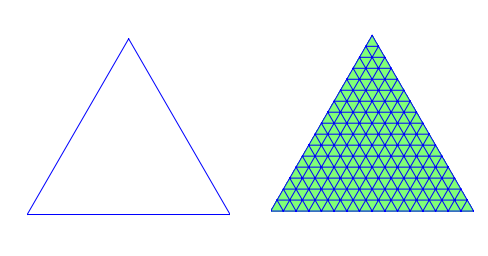

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from functools import reduce

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=4)

plt.figure(figsize=(8, 4))
for (i, mesh) in enumerate((triangle, trimesh)):
    plt.subplot(1, 2, i+ 1)
    plt.triplot(mesh)
    plt.axis('off')
    plt.axis('equal')

midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 \
             for i in range(3)]
def xy2bc(xy, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)
    
class Dir(object):
    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                     reduce(mul, [gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * reduce(mul, [xx ** (aa - 1)
                                         for (xx, aa)in zip(x, self._alpha)])

def draw_pdf(dist, nlevels=200, subdiv=8, **kwargs):
    import math

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    
draw_pdf(d)

In [20]:
d = Dir([1, 1, 1])

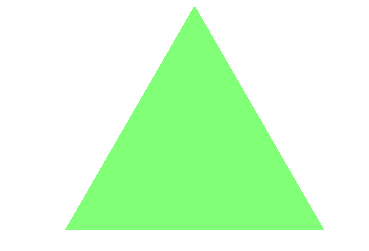

In [21]:
draw_pdf(d)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from functools import reduce

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=4)

plt.figure(figsize=(8, 4))
for (i, mesh) in enumerate((triangle, trimesh)):
    plt.subplot(1, 2, i+ 1)
    plt.triplot(mesh)
    plt.axis('off')
    plt.axis('equal')

midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 \
             for i in range(3)]
def xy2bc(xy, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)
    
class Dir(object):
    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                     reduce(mul, [gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * reduce(mul, [xx ** (aa - 1)
                                         for (xx, aa)in zip(x, self._alpha)])

def draw_pdf(dist, nlevels=200, subdiv=8, **kwargs):
    import math

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')

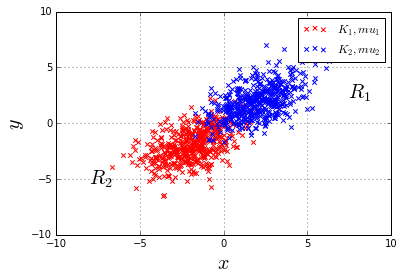

In [6]:
import numpy as np
import matplotlib.pyplot as pylab
 
#平均
mu1 = [-2,-2]
mu2 = [2,2]
#共分散
cov = [[2,1],[1,2]]
 
#500はデータ数
x1,y1 = np.random.multivariate_normal(mu1,cov,500).T
x2,y2 = np.random.multivariate_normal(mu2,cov,500).T
 
#グラフ描画
#背景を白にする
pylab.figure(facecolor="w")
 
#散布図をプロットする
pylab.scatter(x1,y1,color='r',marker='x',label="$K_1,mu_1$")
pylab.scatter(x2,y2,color='b',marker='x',label="$K_2,mu_2$")
 
#ついでにグラフの中に文字を入れてみる
pylab.figtext(0.8,0.6,"$R_1$",size=20)
pylab.figtext(0.2,0.3,"$R_2$",size=20)
 
#ラベル
pylab.xlabel('$x$',size=20)
pylab.ylabel('$y$',size=20)
 
#軸
pylab.axis([-10.0,10.0,-10.0,10.0],size=20)
pylab.grid(True)
pylab.legend()
 
#保存
pylab.savefig("multivariate_normal.png",format = 'png', dpi=200)
pylab.show()
pylab.close()

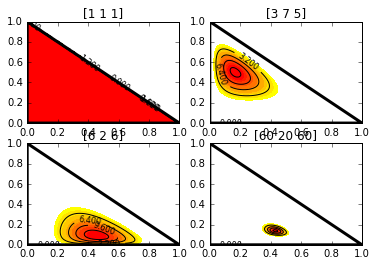

In [25]:
from scipy.special import gammaln
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path

def dirichlet_pdf(xs, alphas):
    if np.any(xs < 0) or np.any(xs > 1):
        return 0
    else:
        ibeta = np.exp(gammaln(alphas.sum()) - gammaln(alphas).sum())
        return ibeta * (xs ** (alphas - 1)).prod()

n_dev = 100
alphas = np.array([[1, 1, 1], [3, 7, 5], [6, 2, 6], [60, 20, 60]])

def plotframe():
    verts = [(0, 0), (1, 0), (0, 1), (0, 0)]
    codes = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, edgecolor='black', facecolor='none', linewidth=3)
    ax.add_patch(patch)

def plotcontour(x, y, z, cmap):
    CS = ax.contourf(X, Y, Z, 20, cmap=cmap)
    #contour line
    CS1 = ax.contour(CS, levels=CS.levels[::4], colors='black')
    #label the contour
    ax.clabel(CS1, inline=1, fontsize=8)

#colormap
colors = [(1, 1, 1)]
colors.extend(mpl.cm.autumn_r(np.linspace(0, 1, 10)))
cmap = mpl.colors.ListedColormap(colors)

x = y = np.linspace(0, 1, num=n_dev)
X, Y = np.meshgrid(x, y)
for i, alpha in enumerate(alphas):
    ax = plt.subplot(int("22"+str(i+1)))
    Z = np.array([
        [dirichlet_pdf(np.array([i, j, 1-i-j]), alpha) for i in x]
        for j in y
        ])
    plotcontour(X, Y, Z, cmap)
    plotframe()
    ax.set_title(str(alpha))

plt.show()

/Users/NIGG/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: covariance is not positive-semidefinite.


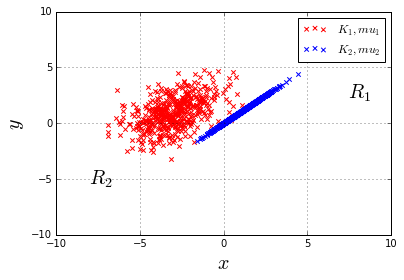

In [7]:
#平均
mu1 = [-3,1]
mu2 = [1,1]
#共分散
cov_1 = [[2,1],[1,2]]
cov_2 = [[1,1],[1,1]]
 
x1,y1 = np.random.multivariate_normal(mu1,cov_1,500).T
x2,y2 = np.random.multivariate_normal(mu2,cov_2,500).T
 
#グラフ描画
#背景を白にする
pylab.figure(facecolor="w")
 
#散布図をプロットする
pylab.scatter(x1,y1,color='r',marker='x',label="$K_1,mu_1$")
pylab.scatter(x2,y2,color='b',marker='x',label="$K_2,mu_2$")
 
#ついでにグラフの中に文字を入れてみる
pylab.figtext(0.8,0.6,"$R_1$",size=20)
pylab.figtext(0.2,0.3,"$R_2$",size=20)
 
#ラベル
pylab.xlabel('$x$',size=20)
pylab.ylabel('$y$',size=20)
 
#軸
pylab.axis([-10.0,10.0,-10.0,10.0],size=20)
pylab.grid(True)
pylab.legend()
 
#保存

Automatically created module for IPython interactive environment


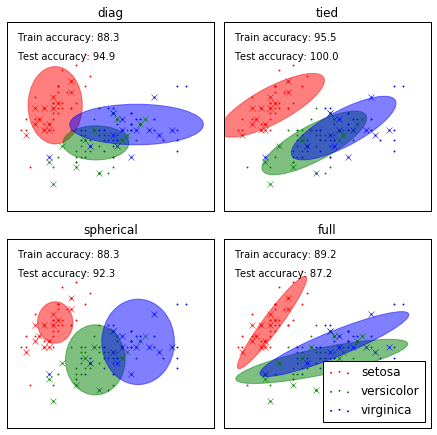

In [4]:
print(__doc__)

# Author: Ron Weiss <ronweiss@gmail.com>, Gael Varoquaux
# License: BSD 3 clause

# $Id$

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from sklearn import datasets
from sklearn.cross_validation import StratifiedKFold
from sklearn.externals.six.moves import xrange
from sklearn.mixture import GMM


def make_ellipses(gmm, ax):
    for n, color in enumerate('rgb'):
        v, w = np.linalg.eigh(gmm._get_covars()[n][:2, :2])
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v *= 9
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

iris = datasets.load_iris()

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(iris.target, n_folds=4)
# Only take the first fold.
train_index, test_index = next(iter(skf))


X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
classifiers = dict((covar_type, GMM(n_components=n_classes,
                    covariance_type=covar_type, init_params='wc', n_iter=20))
                   for covar_type in ['spherical', 'diag', 'tied', 'full'])

n_classifiers = len(classifiers)

plt.figure(figsize=(3 * n_classifiers / 2, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)


for index, (name, classifier) in enumerate(classifiers.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    classifier.means_ = np.array([X_train[y_train == i].mean(axis=0)
                                  for i in xrange(n_classes)])

    # Train the other parameters using the EM algorithm.
    classifier.fit(X_train)

    h = plt.subplot(2, n_classifiers / 2, index + 1)
    make_ellipses(classifier, h)

    for n, color in enumerate('rgb'):
        data = iris.data[iris.target == n]
        plt.scatter(data[:, 0], data[:, 1], 0.8, color=color,
                    label=iris.target_names[n])
    # Plot the test data with crosses
    for n, color in enumerate('rgb'):
        data = X_test[y_test == n]
        plt.plot(data[:, 0], data[:, 1], 'x', color=color)

    y_train_pred = classifier.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = classifier.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(loc='lower right', prop=dict(size=12))


plt.show()